In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osgeo.gdal
from rasterstats import zonal_stats
import rioxarray as rxr
import rasterio as rio
from affine import Affine

import matplotlib.pyplot as plt
import contextily as ctx
import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index")# needed to supress repeated future warning in loop https://github.com/GenericMappingTools/pygmt/issues/1946

In [2]:
fire_path = 'data/Fire_Districts/Fire_Districts.shp'


In [48]:
heat_gdf = gpd.read_file('data/Mesonet/daily_temp.gpkg', layer='temps')
heat_gdf['date_time'] = pd.to_datetime(heat_gdf['date_time'])
district_gdf = gpd.read_file(fire_path)
district_gdf = district_gdf.dissolve(by='District').reset_index() #needed to avoid future merging errors because of split up fire districts

## Heat Interpolation

In [49]:
def InterpolateTemp(temp_gdf:gpd.GeoDataFrame, district_shapes:gpd.GeoDataFrame, date:str, col:str):
    """
    Takes in the the temperature dataframe, fire districts, date to slice by and column to interpolate
    Returns geodataframe in shape of districts_shapes with interpolated mean data for date and col

    temp_gdf --> Geodataframe of weatherstations with data
    districts_shapes --> GeoDataFrame of districts to interpolate to
    date --> date to slice temp_gdf by
    col --> column to interpolate in temp_gdf
    """
    bounds = district_shapes.total_bounds
    temp_station_path = 'data/working/temp_data.shp'
    temp_raster_path = 'data/working/temp_raster.tiff'
    temp_gdf = temp_gdf[['date_time', col, 'geometry']]
    temp_gdf = temp_gdf.rename(columns={col:'z_col'})
    temp_gdf['date_time'] = temp_gdf['date_time'].astype(str) #avoids shapefile error with processing datetime types
    temp_gdf[temp_gdf['date_time']==date].to_file('data/working/temp_data.shp') # slice data by date and create shapefile for interpolating

    rasterDs = osgeo.gdal.Grid(
        temp_raster_path,
        temp_station_path,
        format='GTiff',
        zfield='z_col',
        outputBounds=bounds,
        algorithm='invdist',
    )
    
    rasterDs = None
    del rasterDs

    ### For some reason GDAL creates a raster with unexpected affine transform that begins in lower left corner
    ### we must create an affine transorm with a negative cell height and flip the array to read the data properly for zonal stats

    af = Affine(0.002003195255464829, 0.0, -118.66818799560865,
       0.0, -0.002475198135987511, 34.33730781636643)
    
    
    with rio.open(temp_raster_path) as src:
    # Read the raster data as an array
        raster_array = src.read(1)
        
        # Flip the array vertically
        flipped_array = np.flip(raster_array, axis=0)
        
        # Update the metadata of the raster
        kwargs = src.meta.copy()
        
        # Write the flipped raster to a new file
        with rio.open(temp_raster_path, 'w', **kwargs) as dst:
            dst.write(flipped_array, 1)
            dst.transform = af
        
    data = rio.open(temp_raster_path)
    stats = pd.DataFrame(zonal_stats(district_shapes, data.read(1), affine=af, stats=['mean']))
    stats_gdf = district_shapes.join(stats)
    stats_gdf = stats_gdf.rename(columns={'mean':col})
    stats_gdf['date_time'] = date

    return stats_gdf



<Axes: >

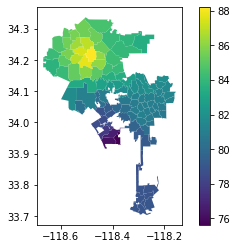

In [52]:
InterpolateTemp(heat_gdf, district_gdf, '2020-06-02', 'heat_index_high').plot(column = 'heat_index_high', legend = True) # test function on random date

In [53]:
days = heat_gdf['date_time'].astype(str).unique() 
len(days)

1827

In [54]:
high_df_list = []
low_df_list = []

for day in days:
    daily_high_gdf = InterpolateTemp(heat_gdf, district_gdf, day, 'heat_index_high')
    high_df_list.append(daily_high_gdf)
    daily_low_gdf = InterpolateTemp(heat_gdf, district_gdf, day, 'heat_index_low')
    low_df_list.append(daily_low_gdf)

high_gdf = pd.concat(high_df_list)
low_gdf = pd.concat(low_df_list)

In [55]:
complete_gdf = high_gdf.merge(low_gdf[['date_time', 'District', 'heat_index_low']], on=['date_time', 'District'])

In [56]:
print(f'Expected len: 186354 \n Observed len: {len(complete_gdf)}') # check expected length to ensure propper merging

Expected len: 186354 
 Observed len: 186354


In [59]:
complete_gdf.sample(5) 

,District,geometry,ObjectID,TOOLTIP,Battalion,Division,Battalion_,District_N,heat_index_high,date_time,heat_index_low
65868,77,"POLYGON ((-118.32279 34.25095, -118.32220 34.2...",67,Fire Battalion: 12\nFire Division: North Divis...,12,North Division,Battalion 12,District 77,81.502548,2019-10-08,58.140069
70162,87,"POLYGON ((-118.51573 34.24309, -118.51564 34.2...",24,Fire Battalion: 15\nFire Division: North Divis...,15,North Division,Battalion 15,District 87,80.662246,2019-11-19,53.456469
104212,7,"POLYGON ((-118.41014 34.23314, -118.41790 34.2...",101,Fire Battalion: 12\nFire Division: North Divis...,12,North Division,Battalion 12,District 7,84.775852,2020-10-18,62.698644
37321,9,"POLYGON ((-118.24540 34.04892, -118.24474 34.0...",77,Fire Battalion: 1\nFire Division: South Divisi...,1,South Division,Battalion 1,District 9,57.537186,2019-01-01,35.080807
181659,97,"POLYGON ((-118.37241 34.13411, -118.37229 34.1...",59,Fire Battalion: 14\nFire Division: North Divis...,14,North Division,Battalion 14,District 97,73.205192,2022-11-17,45.350525


In [60]:
complete_gdf.to_file('data/Final_Data/District_Heat.gpkg', driver='GPKG', layer='heat')

In [61]:
complete_gdf.to_csv('data/Final_Data/District_Heat.csv')